In [93]:
%load_ext blackcellmagic
%matplotlib inline


import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [94]:
ccc_df = pd.read_csv("ccc_blm.csv")
ele_df = pd.read_csv("ele.csv")
cl_df = pd.read_csv("cl_blm.csv")

dfs = [ccc_df, ele_df, cl_df]

In [95]:
df = pd.concat(dfs).reset_index(drop=True)
len(df)

3878

In [96]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

3878

In [97]:
# eliminate non US events

countries = [
    "Finland",
    "England",
    "Wales",
    "Canada",
    "Scotland",
    "Germany",
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium",
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = ", " + c
        if c2 in city_st:
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

3837

In [98]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [99]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [100]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [101]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

First Pass at Aggregation

In [102]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [103]:
df_cd['size_imp'] = df_cd['size'].fillna(11)



In [104]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [105]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Count Love" : "max",
    "Elephrame" : "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [106]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [107]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",

]

In [108]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [109]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [110]:
df_cd.to_csv('blm_post_0625.csv', index =False)
df_cd.to_json('blm_post_0625.json', orient='records')



In [111]:
df_cd = pd.read_csv('blm_post_0625.csv')

In [112]:
df_cd['date'] = pd.to_datetime(df_cd['date'])
date_start = pd.to_datetime('2020-05-24')
date_stop = pd.to_datetime('2020-06-10')

In [113]:
df_cd = df_cd[df_cd['date'] >= date_start].copy()
df_cd = df_cd[df_cd['date'] <= date_stop].sort_values(by=['date','city_st']).copy()

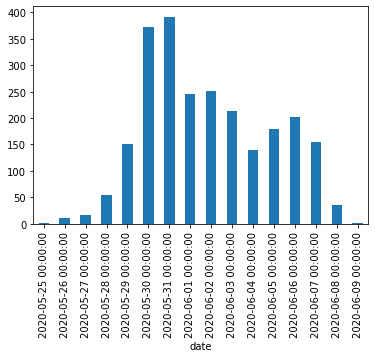

In [114]:
df_cd.groupby('date')['events'].sum().plot(kind='bar');

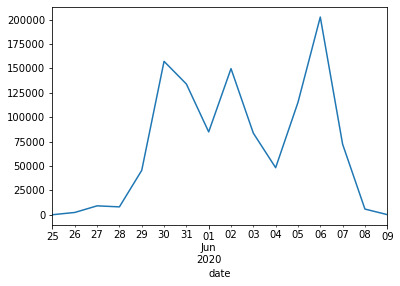

In [115]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [116]:
df_cd['size_imp'].sum()

1118153.0

In [117]:
df_cd['size'].sum()

1110365.0

In [118]:
df_cd['size_imp'].sample(20)

1083     300.0
870      200.0
872     1000.0
1652      24.0
1539      11.0
1379      11.0
1144      50.0
625      600.0
2536    2000.0
2202      40.0
532        6.0
1847     200.0
691      200.0
1478      11.0
1106      40.0
1821      11.0
1262     100.0
1125      11.0
1569     200.0
2473      11.0
Name: size_imp, dtype: float64

In [119]:
df_cd.groupby(["CCC", "Count Love", 'Elephrame']).count()

date  city_st  events  size  size_imp  urls
CCC Count Love Elephrame                                             
0   0          1           237      237     237   216       237   237
    1          0           783      783     783   453       783   783
               1           103      103     103   101       103   103
1   0          0           499      499     499   209       499   499
               1            49       49      49    48        49    49
    1          0           311      311     311   249       311   311
               1           141      141     141   139       141   141

In [120]:
df_cd

,date,city_st,events,size,size_imp,CCC,Count Love,Elephrame,urls
495,2020-05-25,"Tulsa, OK",1,NaN,11.0,0,1,0,['https://kfor.com/news/local/protester-hit-by...
496,2020-05-26,"Ann Arbor, MI",1,36.0,36.0,0,1,1,['https://www.mlive.com/news/2020/05/police-br...
497,2020-05-26,"Chicago, IL",1,24.0,24.0,0,0,1,['https://twitter.com/MikeLoweReports/status/1...
498,2020-05-26,"Hammond, IN",1,NaN,11.0,0,1,0,['https://www.nwitimes.com/news/local/watch-no...
499,2020-05-26,"Houston, TX",1,NaN,11.0,1,1,0,['https://www.houstonchronicle.com/news/housto...
...,...,...,...,...,...,...,...,...,...
2613,2020-06-08,"Rock Springs, WY",1,NaN,11.0,1,0,0,['https://twitter.com/fredseviltwinzy/status/1...
2614,2020-06-08,"San Antonio, TX",1,NaN,11.0,0,1,0,['https://www.kens5.com/article/news/local/liv...
2615,2020-06-08,"Seattle, WA",1,200.0,200.0,0,0,1,['https://twitter.com/chaseburnsy/status/12701...
2616,2020-06-08,"Washington, DC",1,200.0,200.0,0,0,1,['https://twitter.com/AnnaLysaGayle/status/127...
